In [28]:
import neuralnet as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from typing import List, Any
np.random.seed(123)

In [29]:
class Data(nn.DataSource2D):
    _train_in : List[Any]
    _train_out : List[Any]

    def __init__(self):
        super().__init__()
        train_in, _ = pickle.load(open('data/mnist_preprocessed.pickle', 'rb'))
        self._train_in = [np.reshape(x, (28,28,1)) for x in train_in]
        self._train_out = [np.reshape(x, (28,28,1)) for x in train_in]

    def size(self):
        return len(self._train_in)

    def sample(self, i : int):
        return (self._train_in[i], self._train_out[i])

class Model(nn.Model2D):
    def __init__(self):
        super().__init__()
        self._layer1 = nn.Conv2D(1,3)
        self._layer2 = nn.MaxPool2D()
        self._layer3 = nn.Conv2D(3,3)
        self._layer4 = nn.MaxUnPool2D(self._layer2)
        self._layer5 = nn.Conv2D(3,1)
        self._layer6 = nn.Sigmoid2D()
    
    def forward(self, input):
        return  self._layer6.forward(
                    self._layer5.forward(
                        self._layer4.forward(
                            self._layer3.forward(
                                self._layer2.forward(
                                    self._layer1.forward(input)
                                )
                            )
                        )
                    )
                )
    
    def backward(self, error):
        return  self._layer1.backward(
                    self._layer2.backward(
                        self._layer3.backward(
                            self._layer4.backward(
                                self._layer5.backward(
                                    self._layer6.backward(error)
                                )
                            )
                        )
                    )
                )
    
    def update(self, rate):
        self._layer1.update(rate)
        self._layer2.update(rate)
        self._layer3.update(rate)
        self._layer4.update(rate)
        self._layer5.update(rate)
        self._layer6.update(rate)

In [30]:
N = 100
a = 0.00001

In [31]:
model = Model()
data = Data()
trainer = nn.Trainer2D(model, data)

Training of model complete in 4.596292481422425 seconds per epoch.


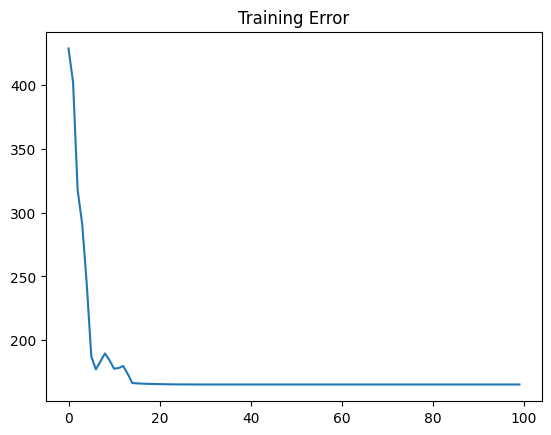

In [32]:
ts = time.time()
errors = trainer.train(N, a)
duration = time.time() - ts
print(f"Training of model complete in {duration / N} seconds per epoch.")

plt.title("Training Error")
plt.plot(range(len(errors)), errors)
plt.show()

In [36]:
sample = data.sample(0)
sample[0].shape

(28, 28, 1)

TypeError: Invalid shape (3,) for image data

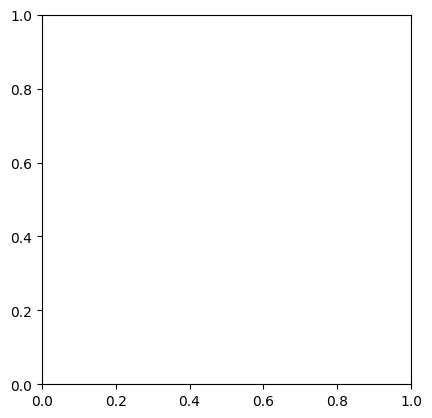

In [ ]:
plt.imshow(sample[0])

In [ ]:

out = model.forward(sample[0])
out.shape

(28, 28, 1)

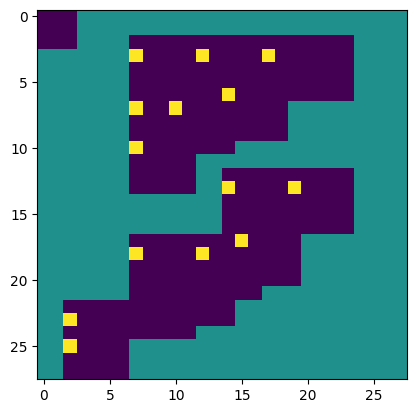

In [ ]:
plt.imshow(out)